## Fundamentos de Aprendizaje Automático

TP Final

Alejandro Said Núñez Selin

## Objetivo:

Se tienen 4 archivos de datos obtenidos utilizando un detector Cherenkov en agua

- 1 par de una fuente de Co60 (gamma) con su respectivo fondo
- 1 par de una fuente de AmBe con plomo (neutrones) con su respectivo fondo

Es necesario medir un fondo aparte pues el detector no puede medir exclusiamente el espectro de la fuente, sino que los archivos donde se mide la fuente también contienen fondo.

Hasta ahora lo que se ha venido haciendo es hallar el espectro de carga de la fuente, hallar el espectro de carga del fondo y restarlos bin a bin.

#### Problema:

Con ese aproach simplemente obtendremos el espectro de carga de la fuente (o de alturas) pero no obtendremos los pulsos reales de la fuente pues están mezclados con el fondo.

Por tanto se plantean como objetivo (no digo que se vaya a cumplir a corto plazo):

-   Intentar sacar los pulsos que pertenecen solamente a la fuente de los archivos de medicion con fuente
-   (Más a futuro) medir con una mayor cantidad de fuentes de diferentes tipos de radiación para caracterizar bien cada tipo de pulsos y poder del fondo natural decir cuáles pulsos pertenecen a cuál tipo de radiación
-   Por ahora me conformo con poder clasificar los pulsos gammas y de neutrones del resto del fondo de partículas

#### Disclaimer:

-   Los neutrones son partículas inestables fuera del núcleo atómico, por tanto se espera que hallan muy pocos neutrones en el fondo y por tanto sean más fáciles de clasificar

-   Los gammas en cambio son estables, y no solamente eso, sino que pueden ser producto de casi cualquier proceso atómico o nuclear, por lo que pueden venir de diferentes fuentes. Se intentarán clasificar pensando en que los gammas emitidos por la fuente son diferentes del resto de gammas del fondo (esto es un porro seguramente)

## Vamos a ver qué encontramos y cómo lo intentamos solucionar en el camino!!

Intentemos primeramente cargar los datos y ver qué forma tienen los pulsos

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import re
import os
import csv

Algunas funciones para reutilizar código

In [11]:
def sub_arr(arr):
    """
    Retorna una sub-array de 'arr' que contiene todos los elementos no negativos (pulso) 
    que se extienden hacia afuera desde el índice 8 hasta que se encuentran elementos negativos en ambos extremos.
    
    Parámetros:
    arr (list): Una lista de números enteros (evento).
    
    Retorna:
    list: Una sub-array de 'arr' con números enteros no negativos (pulso).
    """
    start, end = 8, 8
    while start >= 0 and arr[start] > 0:
        start -= 1
    while end < len(arr) and arr[end] > 0:
        end += 1
    if start == -1 and end == len(arr):
        return []
    if arr[start] < 0:
        start += 1
    if arr[end - 1] < 0:
        end -= 1
    return arr[start:end]

In [12]:
def subsegments(new_data):
    """
    Genera subsegmentos de datos a partir de segmentos proporcionados.

    Parámetros:
    new_data (list): Una lista de listas de números enteros (segmentos de datos).

    Retorna:
    list: Una lista de subsegmentos de datos.
    """
    return [sub_arr(segment) for segment in new_data if len(sub_arr(segment)) > 0]

In [13]:
def load_data(file_list):
    """
    Carga datos de una lista de archivos, calcula los máximos, las sumas y los pulsos promedio.

    Parámetros:
    file_list (list): Una lista de rutas de archivos a cargar.

    Retorna:
    tuple: Tres listas, una con los máximos, otra con las sumas y otra con los pulsos promedio para cada archivo.
    """
    all_max_per_file, all_sum_per_file, mean_pulses = [], [], []
    for file in file_list:
        data = np.loadtxt(file, np.int32, usecols=0)
        print(f'Longitud de {file}: {len(data)}')
        num_segments = len(data) // 32
        new_data = data[:num_segments * 32].reshape(-1, 32)
        mean_pulses.append(np.mean(new_data, axis=0))
        subsegment_data = subsegments(new_data)
        if subsegment_data:
            max_values = [np.max(subsegment) for subsegment in subsegment_data]
            all_max_per_file.append(max_values)
            sum_values = [np.sum(subsegment) for subsegment in subsegment_data]
            all_sum_per_file.append(sum_values)
    return all_max_per_file, all_sum_per_file, mean_pulses

In [14]:
def plot_histogram(data, bin_width, labels, title, x_label, y_label, log_scale=False, xlim=None):
    """
    Genera y muestra un histograma a partir de los datos proporcionados.

    Parámetros:
    data (list): Lista de listas con los datos a graficar.
    bin_width (int): Ancho del bin para el histograma.
    labels (list): Lista de etiquetas para las diferentes series de datos.
    title (str): Título del gráfico.
    x_label (str): Etiqueta del eje x.
    y_label (str): Etiqueta del eje y.
    log_scale (bool): Si True, el eje y estará en escala logarítmica.
    xlim (tuple): Limites en el eje x.
    """
    for d, label in zip(data, labels):
        plt.hist(
            d,
            bins=np.arange(np.min(d), np.max(d), bin_width),
            histtype='step',
            label=label,
            linewidth=1.5
        )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    if log_scale:
        plt.yscale('log')
    if xlim:
        plt.xlim(xlim)
    plt.grid(True)
    plt.show()

In [15]:
def plot_mean_pulses(mean_pulses, labels, title, x_label, y_label):
    """
    Genera y muestra un gráfico de los pulsos promedio.

    Parámetros:
    mean_pulses (list): Lista de listas con los pulsos promedio.
    labels (list): Lista de etiquetas para las diferentes series de datos.
    title (str): Título del gráfico.
    x_label (str): Etiqueta del eje x.
    y_label (str): Etiqueta del eje y.
    """
    for pulse, label in zip(mean_pulses, labels):
        plt.plot(pulse, linewidth=1.5, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

In [16]:
def save_filtered_data(file_list, charge_range, output_dir):
    """
    Filtra y guarda los datos que se encuentran dentro del rango de carga especificado.

    Parámetros:
    file_list (list): Lista de archivos a procesar.
    charge_range (tuple): Rango de carga (min, max) para filtrar los datos.
    output_dir (str): Directorio donde se guardarán los archivos filtrados.
    """
    fuente_data, fondo_data = [], []
    fuente_file, fondo_file = file_list
    for file, data_list in zip([fuente_file, fondo_file], [fuente_data, fondo_data]):
        data = np.loadtxt(file, np.int32, usecols=0)
        num_segments = len(data) // 32
        segments = data[:num_segments * 32].reshape(-1, 32)
        subsegment_data = subsegments(segments)
        if subsegment_data:
            for index, subsegment in enumerate(subsegment_data):
                if charge_range[0] < np.sum(subsegment) < charge_range[1]:
                    data_list.append(segments[index])
    os.makedirs(output_dir, exist_ok=True)
    if fuente_data:
        np.savetxt(os.path.join(output_dir, "fuente_pulsos.csv"), np.array(fuente_data), delimiter=',', fmt='%d')
    if fondo_data:
        np.savetxt(os.path.join(output_dir, "fondo_pulsos.csv"), np.array(fondo_data), delimiter=',', fmt='%d')
    print(f"Datos guardados en {output_dir}")

Reemplazar en caso que la dirección de los archivos sea otra (Estos archivos no se van a subir, son muy pesados, y tampoco son necesarios luego de ser procesados)

In [17]:
file_list_Co = sorted(glob.glob('data/*Co*'))
file_list_AmBe_plomo = sorted(glob.glob('data/*10cm_plomo*'))

Cálculo de las alturas, la carga y el pulso promedio, empecemos con el Co60

In [18]:
all_max_per_file_Co, all_sum_per_file_Co, mean_pulses_Co = load_data(file_list_Co)

Longitud de data/Co_1200V_170t1_5min.dat: 95742672
Longitud de data/fondo_Co_1200V_170t1_5min.dat: 59981350


Vamos a ver los histogramas de carga y los pulsos medios respectivamente de los espectros

Veamos todo el rango energético primero

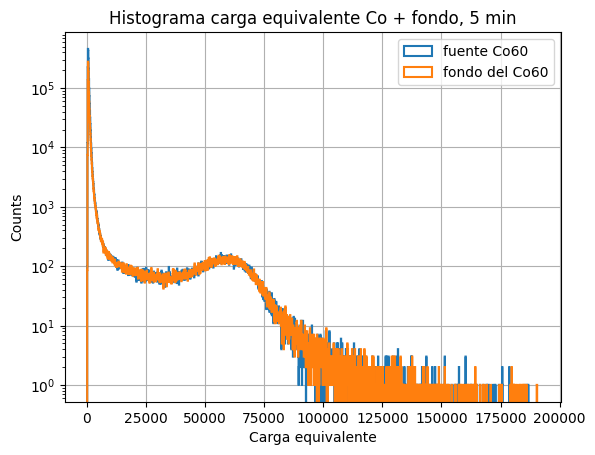

In [19]:
plot_histogram(
    all_sum_per_file_Co, 
    bin_width=100, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Histograma carga equivalente Co + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

La parte donde actúa la fuente parece ser la de baja energía

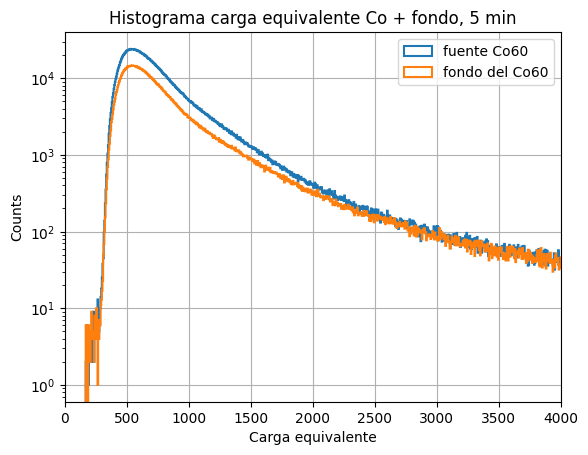

In [20]:
plot_histogram(
    all_sum_per_file_Co, 
    bin_width=5, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Histograma carga equivalente Co + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(0, 4000)
)

Veamos ahora los pulsos medios

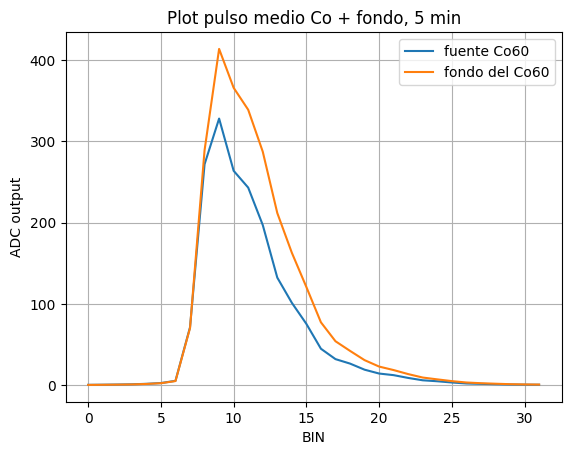

In [21]:
plot_mean_pulses(
    mean_pulses_Co, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Plot pulso medio Co + fondo, 5 min', 
    x_label='BIN', 
    y_label='ADC output'
)

Los pulsos medios son muy similares, la forma de la señal parece ser mas menos la misma, pero los pulsos del fondo parecen más altos, lo más probable es que sea porque hay una mayor cantidad de cuentas en la parte de baja energía para la medición con fuente, eso afecta la estadística a la hora de hacer un promedio.

Anyways guardemos una parte del espectro del fondo y la fuente, de 500 a 600 en carga parece bien, hay bastante población de la fuente en ese rango energético

In [22]:
charge_thresholds_Co = (500, 600)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_Co, charge_thresholds_Co, "Co60")

Datos guardados en Co60


Libreremos memoria con lo que ya no se va a utilizar

In [23]:
del all_max_per_file_Co
del all_sum_per_file_Co
del mean_pulses_Co

Vamos a por los neutrones ahora

In [25]:
file_list_AmBe_plomo = sorted(glob.glob('data/*10cm_plomo*'))
all_max_per_file_AmBe, all_sum_per_file_AmBe, mean_pulses_AmBe = load_data(file_list_AmBe_plomo)

Longitud de data/AmBe_30cm_10cm_plomo_1200V_650t1_5min.dat: 96712340
Longitud de data/fondo_10cm_plomo_1200V_170t1_5min.dat: 63388416


Nuevamente veamos todo el rango energético

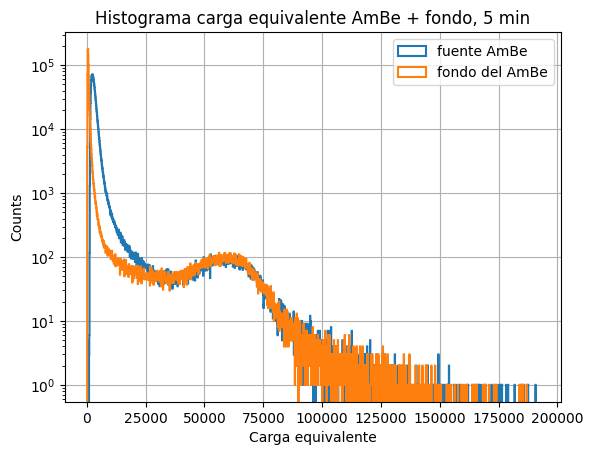

In [26]:
plot_histogram(
    all_sum_per_file_AmBe, 
    bin_width=100, 
    labels=['fuente AmBe', 'fondo del AmBe'], 
    title='Histograma carga equivalente AmBe + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

Hagamos zoom donde actúa la fuente

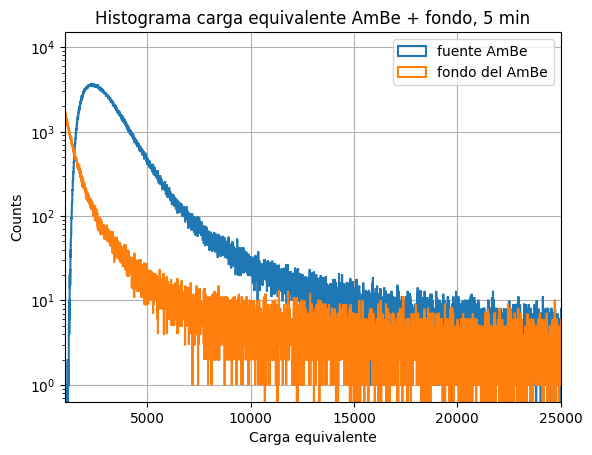

In [27]:
plot_histogram(
    all_sum_per_file_AmBe, 
    bin_width=5, 
    labels=['fuente AmBe', 'fondo del AmBe'], 
    title='Histograma carga equivalente AmBe + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(1000, 25000)
)

Y el pulso medio

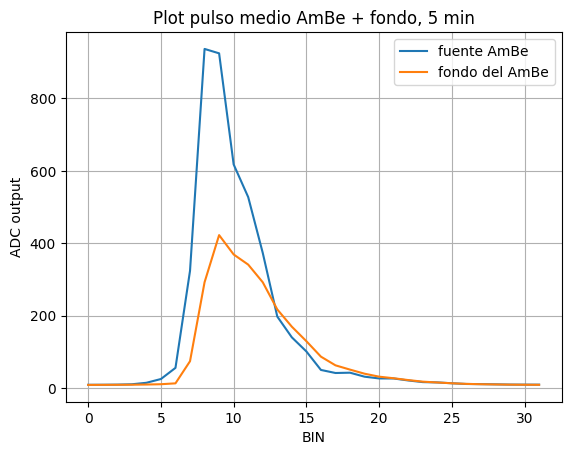

In [28]:
plot_mean_pulses(
    mean_pulses_AmBe, 
    labels=['fuente AmBe', 'fondo del AmBe'], 
    title='Plot pulso medio AmBe + fondo, 5 min', 
    x_label='BIN', 
    y_label='ADC output'
)

Los pulsos medios son muy diferentes en este caso, deben ser más clasificables los neutrones

Nuevamente guardemos un pedazo del espectro, de 4000 - 6000 parece bien

In [29]:
charge_thresholds_AmBe = (4000, 6000)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_AmBe_plomo, charge_thresholds_AmBe, "AmBe")

Datos guardados en AmBe


In [30]:
del all_max_per_file_AmBe
del all_sum_per_file_AmBe
del mean_pulses_AmBe

Estuve pensando cuántas dimensiones usar en el clasificador, primeramente pensé en 5, siendo estas, carga del pulso, altura, tiempo de subida (posición donde se alcanza el máximo), tiempo de bajada y ancho, pero luego caí en cuenta que como todos los pulsos tienen un ancho de 32 valores,
#### Podemos usar las 32 dimensiones!!
total una imagen de baja calidad es más que eso

Carguemos los csv y veamos los pulsos medios de solamente la parte energética que se está analizando en cada caso

In [3]:
def load_csv_data(file_path):
    """
    Carga datos desde un archivo CSV.

    Parámetros:
    file_path (str): Ruta al archivo CSV.

    Retorna:
    np.array: Array con los datos cargados.
    """
    return np.loadtxt(file_path, delimiter=',')

def calculate_mean_pulse(data):
    """
    Calcula el pulso medio a partir de los datos proporcionados.

    Parámetros:
    data (np.array): Datos desde los cuales calcular el pulso medio.

    Retorna:
    np.array: Pulso medio calculado.
    """
    return np.mean(data, axis=0)

def plot_mean_pulses(mean_pulses, labels, title, x_label, y_label):
    """
    Genera y muestra un gráfico de múltiples pulsos medios.

    Parámetros:
    mean_pulses (list of np.array): Lista de pulsos medios a graficar.
    labels (list of str): Lista de etiquetas para cada serie de datos.
    title (str): Título del gráfico.
    x_label (str): Etiqueta del eje x.
    y_label (str): Etiqueta del eje y.
    """
    for mean_pulse, label in zip(mean_pulses, labels):
        plt.plot(mean_pulse, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
# Rutas a los archivos CSV generados
co_fuente_csv = "Co60/fuente_pulsos.csv"
co_fondo_csv = "Co60/fondo_pulsos.csv"
ambe_fuente_csv = "AmBe/fuente_pulsos.csv"
ambe_fondo_csv = "AmBe/fondo_pulsos.csv"

# Cargar los datos desde los archivos CSV
co_fuente_data = load_csv_data(co_fuente_csv)
co_fondo_data = load_csv_data(co_fondo_csv)
ambe_fuente_data = load_csv_data(ambe_fuente_csv)
ambe_fondo_data = load_csv_data(ambe_fondo_csv)

Miremos un poco los pulsos que guardamos en los csv

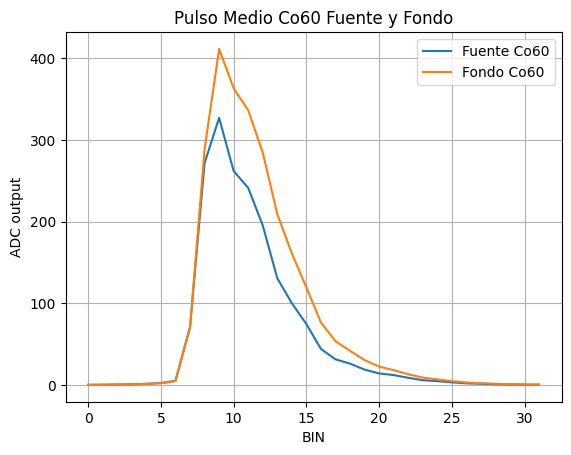

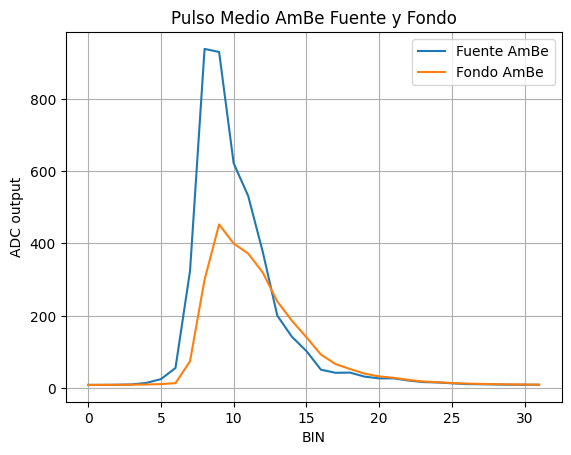

In [7]:
# Calcular los pulsos medios
co_fuente_mean_pulse = calculate_mean_pulse(co_fuente_data)
co_fondo_mean_pulse = calculate_mean_pulse(co_fondo_data)
ambe_fuente_mean_pulse = calculate_mean_pulse(ambe_fuente_data)
ambe_fondo_mean_pulse = calculate_mean_pulse(ambe_fondo_data)

# Graficar los pulsos medios de Co (fuente y fondo)
plot_mean_pulses(
    mean_pulses=[co_fuente_mean_pulse, co_fondo_mean_pulse], 
    labels=['Fuente Co60', 'Fondo Co60'], 
    title='Pulso Medio Co60 Fuente y Fondo', 
    x_label='BIN', 
    y_label='ADC output'
)

# Graficar los pulsos medios de AmBe (fuente y fondo)
plot_mean_pulses(
    mean_pulses=[ambe_fuente_mean_pulse, ambe_fondo_mean_pulse], 
    labels=['Fuente AmBe', 'Fondo AmBe'], 
    title='Pulso Medio AmBe Fuente y Fondo', 
    x_label='BIN', 
    y_label='ADC output'
)

La forma del pulso de fondo de la fuente de neutrones se parece mucho al fondo de la parte de Co que a su vez se parece mucho a la propia fuente de Co60, todo parece indicar que en efecto hay muchos gammas en el fondo

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Crear etiquetas: 0 para fondo y 1 para fuente

In [10]:
fondo_labels = np.zeros(ambe_fondo_data.shape[0])
fuente_labels = np.ones(ambe_fuente_data.shape[0])

# Unir los datos y etiquetas
data = np.vstack((ambe_fondo_data, ambe_fuente_data))
labels = np.hstack((fondo_labels, fuente_labels))

Dividir en entrenamiento y prueba

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

Vamos a intentar entrenando un modelo de Random Forest

In [12]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluar el modelo
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.90%


Bastante bien! Ahora hagamos una prediccion de los datos de la fuente y filtremos los pulsos del fondo

In [13]:
predicted_labels = clf.predict(ambe_fuente_data)

net_pulses = ambe_fuente_data[predicted_labels == 1]

Veamos los pulsos medios en cada caso

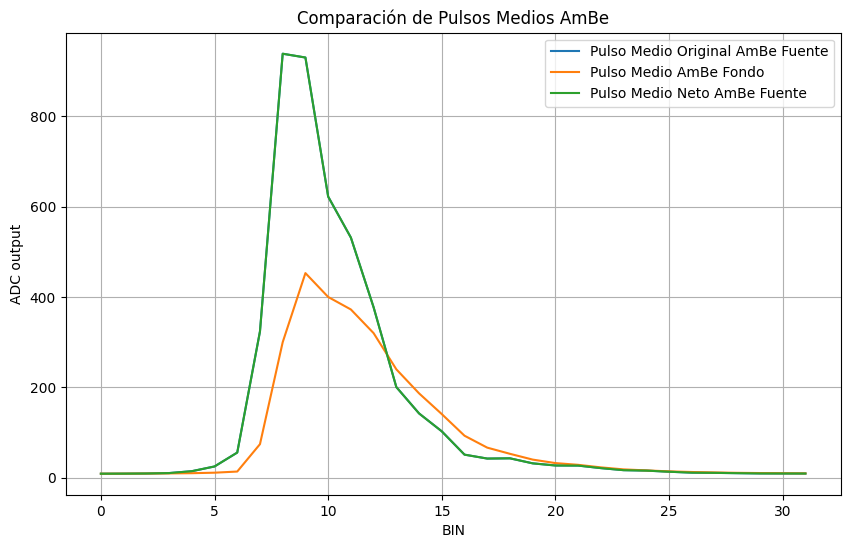

In [14]:
def plot_mean_pulses(data_list, labels, title):
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño del gráfico según tus necesidades
    
    for i, data in enumerate(data_list):
        mean_pulse = np.mean(data, axis=0)
        plt.plot(mean_pulse, linewidth=1.5, label=labels[i])
    
    plt.xlabel('BIN')
    plt.ylabel('ADC output')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_mean_pulses(
    [ambe_fuente_data, ambe_fondo_data, net_pulses],
    ['Pulso Medio Original AmBe Fuente', 'Pulso Medio AmBe Fondo', 'Pulso Medio Neto AmBe Fuente'],
    'Comparación de Pulsos Medios AmBe'
)

Intentemos hacer lo mismo con el Co60

In [19]:
# Crear etiquetas: 0 para fondo y 1 para fuente
fondo_labels = np.zeros(co_fondo_data.shape[0])
fuente_labels = np.ones(co_fuente_data.shape[0])

# Unir los datos y etiquetas
data = np.vstack((co_fondo_data, co_fuente_data))
labels = np.hstack((fondo_labels, fuente_labels))

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [20]:
# Entrenar un modelo de Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluar el modelo
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 61.72%


:(

In [21]:
# Predicción en los datos de fuente
predicted_labels = clf.predict(co_fuente_data)

# Filtrar pulsos de fondo
net_pulses = co_fuente_data[predicted_labels == 1]

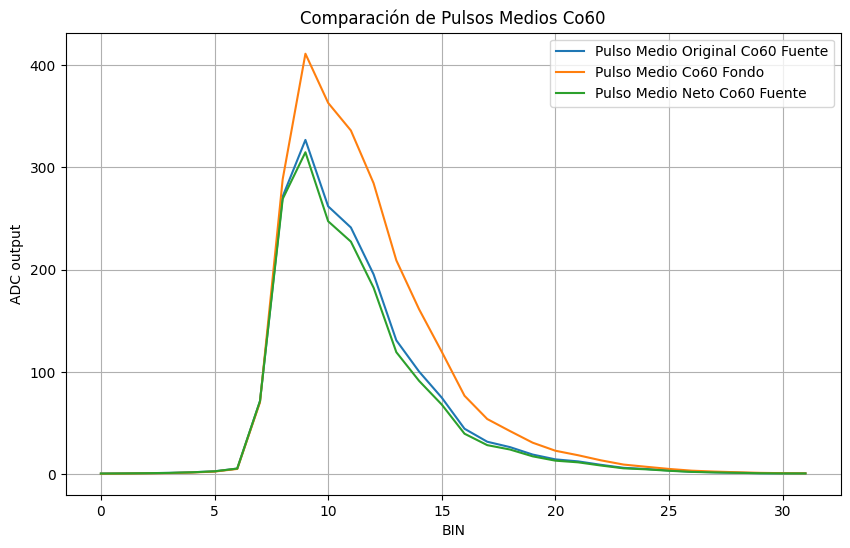

In [22]:
plot_mean_pulses(
    [co_fuente_data, co_fondo_data, net_pulses],
    ["Pulso Medio Original Co60 Fuente", "Pulso Medio Co60 Fondo", "Pulso Medio Neto Co60 Fuente"],
    'Comparación de Pulsos Medios Co60'
)

A partir de acá voy a intentar mejorar el modelo para los gammas en lo que se pueda, luego voy a intentar pasarle varios pulsos aleatorios de un fondo a ver si se pueden clasificar como gammas o neutrones u otra cosa